<a href="https://colab.research.google.com/github/GabrieleSgroi/hierarchical-VQ-VAE/blob/main/Example_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hierarchical Vector Quantized Variational Autoencoder example notebook

In this notebook I will show some example utilization of my project [Hierarchical VQ-VAE](https://github.com/GabrieleSgroi/hierarchical-VQ-VAE) for image generation. 

In [ ]:
#Install and import dependencies
!pip install git+https://github.com/GabrieleSgroi/hierarchical-VQ-VAE.git
!pip install googledrivedownloader


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

  Cloning https://github.com/GabrieleSgroi/hierarchical-VQ-VAE.git to /tmp/pip-req-build-bucyamjn
  Running command git clone -q https://github.com/GabrieleSgroi/hierarchical-VQ-VAE.git /tmp/pip-req-build-bucyamjn
  Created wheel for Hierarchical-VQ-VAE: filename=Hierarchical_VQ_VAE-0.0.0-cp37-none-any.whl size=31919286 sha256=c7adff3abee3a1eb548556c7370bbdc4ceb848f24a296eabd87a995a7c43b647
  Stored in directory: /tmp/pip-ephem-wheel-cache-21i9qlze/wheels/f6/aa/1b/369eb2a6ca2bbc6146a6c549fbdd0113377e837fa856f15390
Successfully built Hierarchical-VQ-VAE


##Image encoding and reconstruction


Let's visualize how an image is encoded into indices and reconstructed from them.

Note: the image is taken from the test set (thus not used during training) of the Kaggle competition [Humpback Whale Identification](https://www.kaggle.com/c/humpback-whale-identification). Colab do not store images between different reruns of a Notebook, so if you wish to run the cell an image has to be uploaded. The model has been trained exclusively on images of whale tails, images that differ significatively from these will lead to poor results.

14573568/14572672 [==============================] - 0s 0us/step


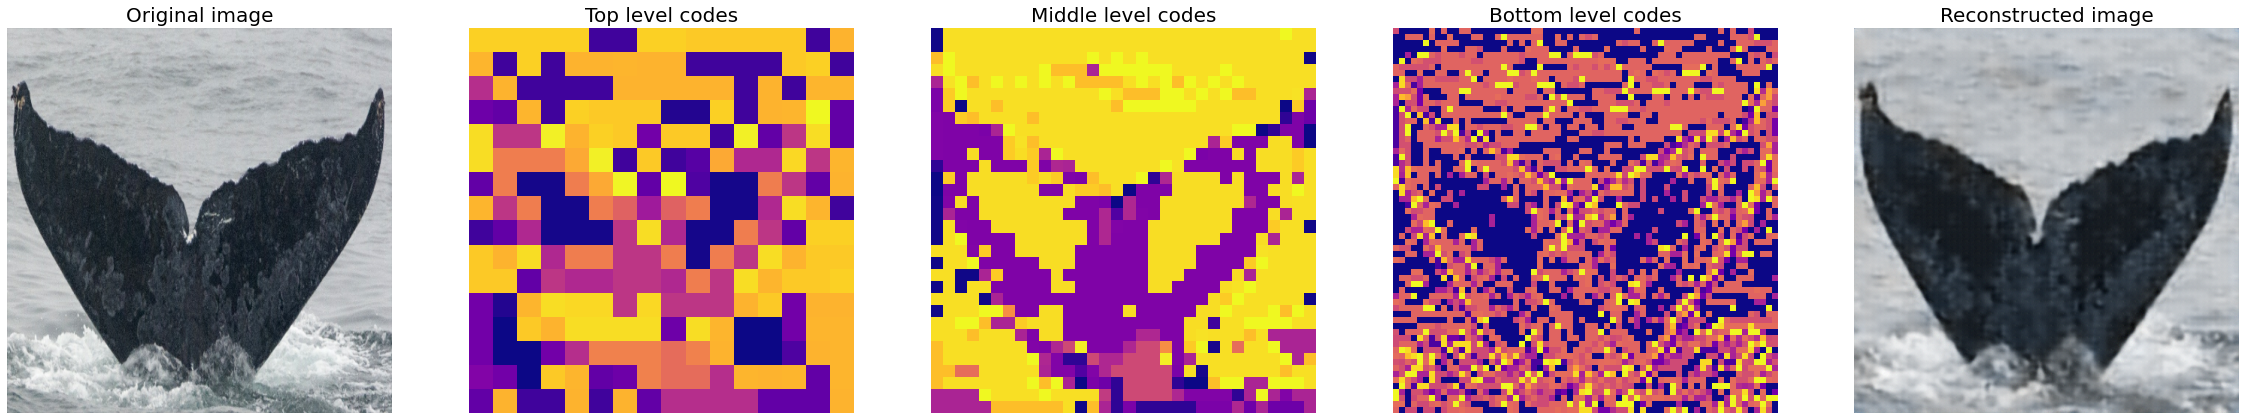

In [ ]:
from PIL import Image
import matplotlib.image as mpimg
from HVQVAE.hyperparameters import KT,DT,KM,DM,KB,DB
from HVQVAE.utils import encode_images_indices
from HVQVAE.load_utils import load_VQVAE

#Path to the image to be encoded and reconstructed
img_path='/content/0170f741c.jpg' 
#Load the model
vqvae=load_VQVAE()

#Decode the image to tf tensor
img = tf.io.read_file(img_path) 
img = tf.image.decode_jpeg(img, channels=3)
#Resize the image to 512
img_size=512
img=tf.image.resize(img, [img_size,img_size])
img=img/255. #Scale intensity of pixels to (0,1)
img=tf.reshape(img, [1,512,512,3]) #Reshape image to include batch size

#Return the encoded hierarchical indices 
top_indices, mid_indices, bot_indices=encode_images_indices(img)
predicted=vqvae.predict(img) #Return reconstructed image

#Visualization
fig, ax=plt.subplots(1,5, figsize=(40,10))
ax[0].imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
ax[0].set_title('Original image', fontsize=20)
ax[1].imshow(top_indices[0], cmap='plasma')
ax[1].set_title('Top level codes', fontsize=20)
ax[2].imshow(mid_indices[0], cmap='plasma')
ax[2].set_title('Middle level codes', fontsize=20)
ax[3].imshow(bot_indices[0],cmap='plasma')
ax[3].set_title('Bottom level codes', fontsize=20)
ax[4].imshow(tf.keras.preprocessing.image.array_to_img(predicted[0]))
ax[4].set_title('Reconstructed image', fontsize=20)
for i in range(5):
    ax[i].axis('off')
plt.show()

As we can see, despite the huge compression from the original 512x512x3 original image to the 16x16, 32x32, 64x64 latent codes the model is able to reconstruct the image with minimal quality loss.

## Generate new images conditioned on a sample image

If we provide an image, we can use the priors to generate new images that will be similar to the given image. To do so, we encode the image top level codes and generate new middle and bottom level codes conditioned on the top level codes obtained from the original image. 

Note: the image is taken from the test set (thus not used during training) of the Kaggle competition [Humpback Whale Identification](https://www.kaggle.com/c/humpback-whale-identification). Colab do not store images between different reruns of a Notebook, so if you wish to run the cell an image has to be uploaded. The model has been trained exclusively on images of whale tails, images that differ significatively from these will lead to poor results.

Note: autoregressive generation pixel by pixel is known to be slow, it takes around 25 mins to generate a batch of 10 images with Colab free GPU. 

Top prior loaded
Mid prior loaded
Bot prior loaded
Original image and embedding codes


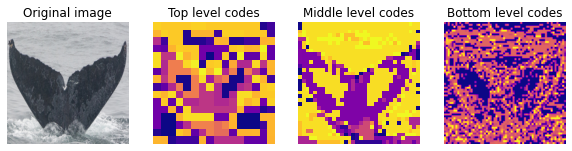

N/A% (0 of 32) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Sampling codes from the middle prior...


100% (32 of 32) |########################| Elapsed Time: 0:04:49 Time:  0:04:49
N/A% (0 of 64) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Sampling codes from the bottom prior...


100% (64 of 64) |########################| Elapsed Time: 0:21:21 Time:  0:21:21
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


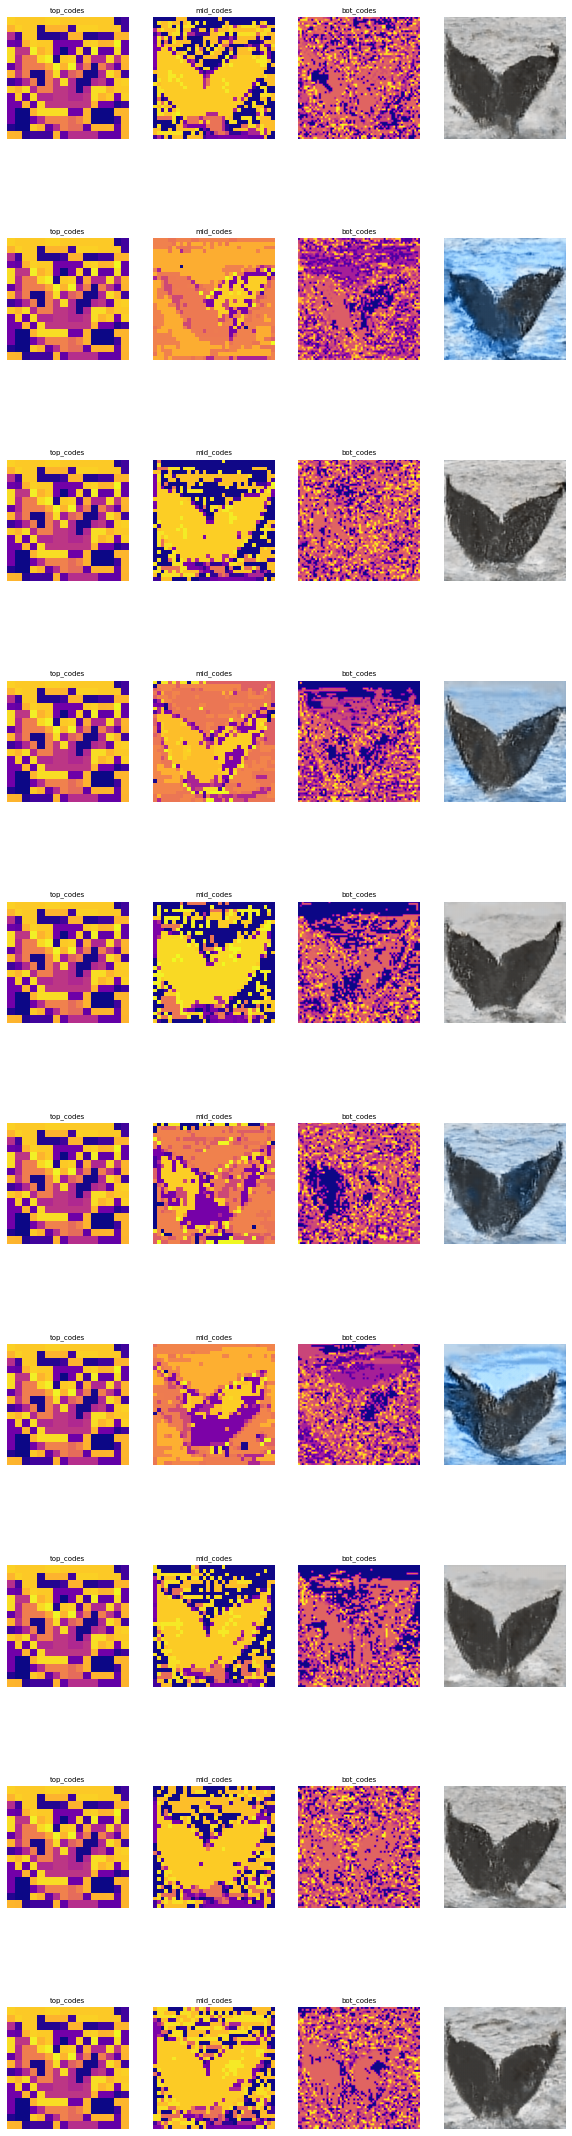

In [ ]:
from PIL import Image
from HVQVAE.utils import encode_images_indices
from HVQVAE.priors.top_prior import build_top_prior
from HVQVAE.priors.mid_prior import build_mid_prior
from HVQVAE.priors.bot_prior import build_bot_prior
from HVQVAE.sampling_utils import sampler, sample_from_bottom_prior, sample_from_mid_prior
from HVQVAE.load_utils import load_decoder, load_top_quantizer, load_mid_quantizer, load_bot_quantizer
from HVQVAE.utils import get_codebook, codebook_from_index

#path to the desired image. Upload before running the cell.
image_path='/content/0170f741c.jpg'  
n_images=10 #Number of new images to generate

#Download prior weights from Google Drive
gdd.download_file_from_google_drive(file_id='1YymD8O87uTBsxnAZd6aYaSUpFkRcj7ls',
                                    dest_path='./top_prior_weights.h5')
gdd.download_file_from_google_drive(file_id='1SuLfHMqzTLbq_ghZAs0pZ1Uwq4fVhHf5',
                                    dest_path='./mid_prior_weights.h5')
gdd.download_file_from_google_drive(file_id='10JlEzNEQdfdI87ff8yFgn_jtVW15IE3l',
                                    dest_path='./bot_prior_weights.h5')


#Load top prior
top_prior=build_top_prior()
top_prior.load_weights('/content/top_prior_weights.h5',)
print('Top prior loaded')

#Load mid prior
mid_prior=build_mid_prior()
mid_prior.load_weights('/content/mid_prior_weights.h5')
print('Mid prior loaded')

#Load bot prior
bot_prior=build_bot_prior()
bot_prior.load_weights('/content/bot_prior_weights.h5')
print('Bot prior loaded')

#Open image and resize to the size used in training
img_size=512
img=Image.open(image_path)
img=img.resize((img_size,img_size), Image.ANTIALIAS)
img=np.array(img)
img=img/255. #scale image entries
img=np.reshape(img, [1,512,512,3])

#Get latent codes from the image
top_indices, mid_indices, bot_indices=encode_images_indices(img)
 
#Visualize latent codes
print('Original image and embedding codes')
fig, axs = plt.subplots(1,4, figsize=(10,5))
axs[0].imshow(img[0])
axs[0].set_title('Original image')
axs[1].imshow(top_indices[0], cmap='plasma')
axs[1].set_title('Top level codes')
axs[2].imshow(mid_indices[0], cmap='plasma')
axs[2].set_title('Middle level codes')
axs[3].imshow(bot_indices[0],cmap='plasma')
axs[3].set_title('Bottom level codes')

for i in range(4):
    axs[i].axis('off')
plt.show()


#Create n_images copies of the indices
top_indices=np.repeat(top_indices, n_images, axis=0)
mid_indices=np.repeat(mid_indices, n_images,  axis=0)
bot_indices=np.repeat(bot_indices, n_images, axis=0)

#Generete new middle-level indices from the top indices extracted from the original image
new_mid_indices=sample_from_mid_prior(10, mid_prior, top_indices)
#Generete new bottom-level indices from the top indices extracted from the original image and the new middle indices
new_bot_indices=sample_from_bottom_prior(10, bot_prior, top_indices, new_mid_indices)

#Generate images from new indices
decoder=load_decoder()
top_quantizer=load_top_quantizer()
mid_quantizer=load_mid_quantizer()
bot_quantizer=load_bot_quantizer()
top_codebook=get_codebook(top_quantizer)
mid_codebook=get_codebook(mid_quantizer)
bot_codebook=get_codebook(bot_quantizer)
tq=codebook_from_index(top_codebook, top_indices)
mq=codebook_from_index(mid_codebook, new_mid_indices)
bq=codebook_from_index(bot_codebook, new_bot_indices)
reconstructed=decoder.predict([tq, mq, bq])


#Visualize new images
plt.figure(figsize=(n_images,40))

for i in range(n_images):
        plt.subplot(n_images,4,1+ 4*i)
        plt.imshow(top_indices[i], cmap='plasma')
        plt.title("top_codes", fontsize=7)
        plt.axis('off')
        plt.subplot(n_images,4,2+ 4*i)
        plt.imshow(new_mid_indices[i], cmap='plasma')
        plt.title("mid_codes", fontsize=7)
        plt.axis('off')
        plt.subplot(n_images,4,3+ 4*i)
        plt.imshow(new_bot_indices[i], cmap='plasma')
        plt.title("bot_codes", fontsize=7)
        plt.axis('off')
        plt.subplot(n_images,4,4+ 4*i)
        plt.imshow(reconstructed[i,:,:,:])
        plt.axis('off')
        plt.savefig("New conditioned image {}".format(i))

#Save figures in files 
for i in range(n_images):
    im = Image.fromarray((np.clip(reconstructed[i,:,:,:], 0, 1)*255).astype(np.uint8))
    im.save("New conditioned image {}.jpeg".format(i))

We observe that all the new samples, although different from the original image, still mantain the global structure, size and position of the tail. Interestingly, some images get colorized: the train set included in fact both black and white and colored images. Apparently the color of the image is not embedded in the top level codes that indeed just capture the global geometric information of the image.

## Generate new images from scratch

We can also generate completely new images by using all three priors.  


Note: autoregressive generation pixel by pixel is known to be slow, it takes around 25 mins to generate a batch of 10 images with Colab free GPU. 

Top prior loaded
Mid prior loaded
Bot prior loaded


N/A% (0 of 16) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Sampling codes from the top prior...


100% (16 of 16) |########################| Elapsed Time: 0:00:50 Time:  0:00:50
N/A% (0 of 32) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Sampling codes from the middle prior...


100% (32 of 32) |########################| Elapsed Time: 0:04:48 Time:  0:04:48
N/A% (0 of 64) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Sampling codes from the bottom prior...


100% (64 of 64) |########################| Elapsed Time: 0:21:31 Time:  0:21:31
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range f

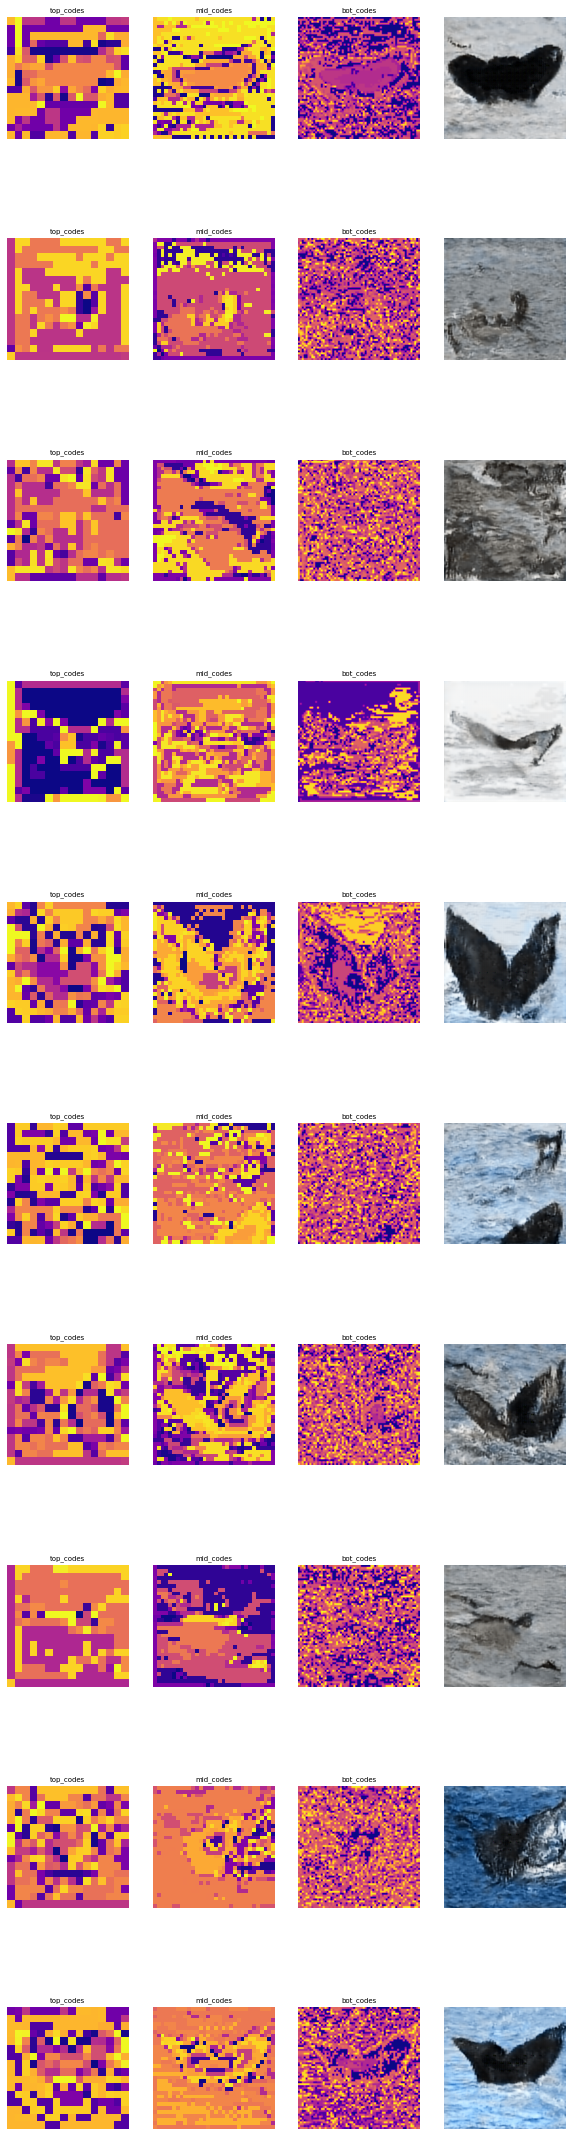

In [ ]:
from HVQVAE.priors.top_prior import build_top_prior
from HVQVAE.priors.mid_prior import build_mid_prior
from HVQVAE.priors.bot_prior import build_bot_prior
from HVQVAE.sampling_utils import generate
from PIL import Image

n_images=10 #Number of images to generate

#Download prior weights from Google Drive
gdd.download_file_from_google_drive(file_id='1YymD8O87uTBsxnAZd6aYaSUpFkRcj7ls',
                                    dest_path='./top_prior_weights.h5')
gdd.download_file_from_google_drive(file_id='1SuLfHMqzTLbq_ghZAs0pZ1Uwq4fVhHf5',
                                    dest_path='./mid_prior_weights.h5')
gdd.download_file_from_google_drive(file_id='10JlEzNEQdfdI87ff8yFgn_jtVW15IE3l',
                                    dest_path='./bot_prior_weights.h5')


#Load top prior
top_prior=build_top_prior()
top_prior.load_weights('/content/top_prior_weights.h5',)
print('Top prior loaded')

#Load mid prior
mid_prior=build_mid_prior()
mid_prior.load_weights('/content/mid_prior_weights.h5')
print('Mid prior loaded')

#Load bot prior
bot_prior=build_bot_prior()
bot_prior.load_weights('/content/bot_prior_weights.h5')
print('Bot prior loaded')

#Generate new codes
generated, top_codes, mid_codes, bot_codes=generate(n_images, top_prior, mid_prior, bot_prior)

plt.figure(figsize=(n_images,40))
for i in range(n_images):
        plt.subplot(n_images,4,1+ 4*i)
        plt.imshow(top_codes[i], cmap='plasma')
        plt.title("top_codes", fontsize=7)
        plt.axis('off')
        plt.subplot(n_images,4,2+ 4*i)
        plt.imshow(mid_codes[i], cmap='plasma')
        plt.title("mid_codes", fontsize=7)
        plt.axis('off')
        plt.subplot(n_images,4,3+ 4*i)
        plt.imshow(bot_codes[i], cmap='plasma')
        plt.title("bot_codes", fontsize=7)
        plt.axis('off')
        plt.subplot(n_images,4,4+ 4*i)
        plt.imshow(generated[i,:,:,:])
        plt.axis('off')

#Save each figure in its own file 
for i in range(n_images):
    im = Image.fromarray((np.clip(generated[i,:,:,:], 0, 1)*255).astype(np.uint8))
    im.save("New unconditioned image {}.jpeg".format(i))

We see that some of the images now don't have the clearly recognizable structure of a whale tail. This may be due to the fact that models like this trained with maximum likelihood are forced to model the entire data distribution. To improve the visual quality of the results some sample selection procedure to trade-off diversity with quality must be used. In the original paper [Generating Diverse High-Fidelity Images with VQ-VAE-2](https://arxiv.org/pdf/1906.00446.pdf), they used a pre-trained classifier trained on Imagenet. Since due to hardware limitations we are dealing with a limited amount of samples, it is easier to just handpick the preferred samples.